<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/convnet_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Deep Learning for Computer Vision - ConvNet Visualization

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Visualizing intermediate activations
in Colab we upload the weigths of the model trained on the Kaggles's cats&dogs dataset

In [5]:
from google.colab import files
files.upload();

Saving convnet_from_scratch_with_augmentation.keras to convnet_from_scratch_with_augmentation (1).keras


In [6]:
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [8]:
from PIL import Image
img_path = keras.utils.get_file(fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
img_cat = Image.open(img_path)
img_cat.size

80329/80329 [==============================] - 0s 2us/step


(500, 500)

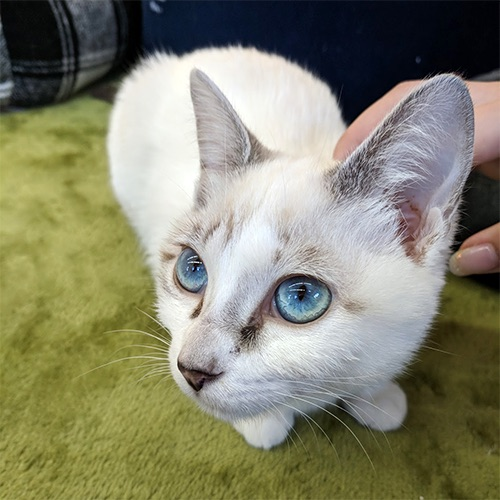

In [9]:
img_cat

In [10]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

We resize the image from 500x500 pixels to 180x180, the input size expected by the model

In [11]:
img_tensor = get_img_array(img_path, target_size=(180, 180))

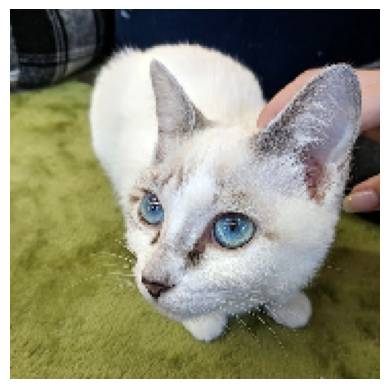

In [12]:
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [15]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [16]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 1s 604ms/step


In [17]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


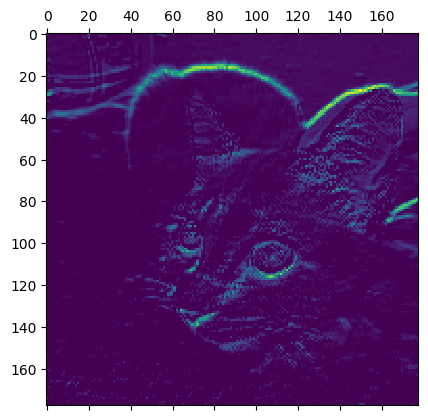

In [23]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap="viridis")

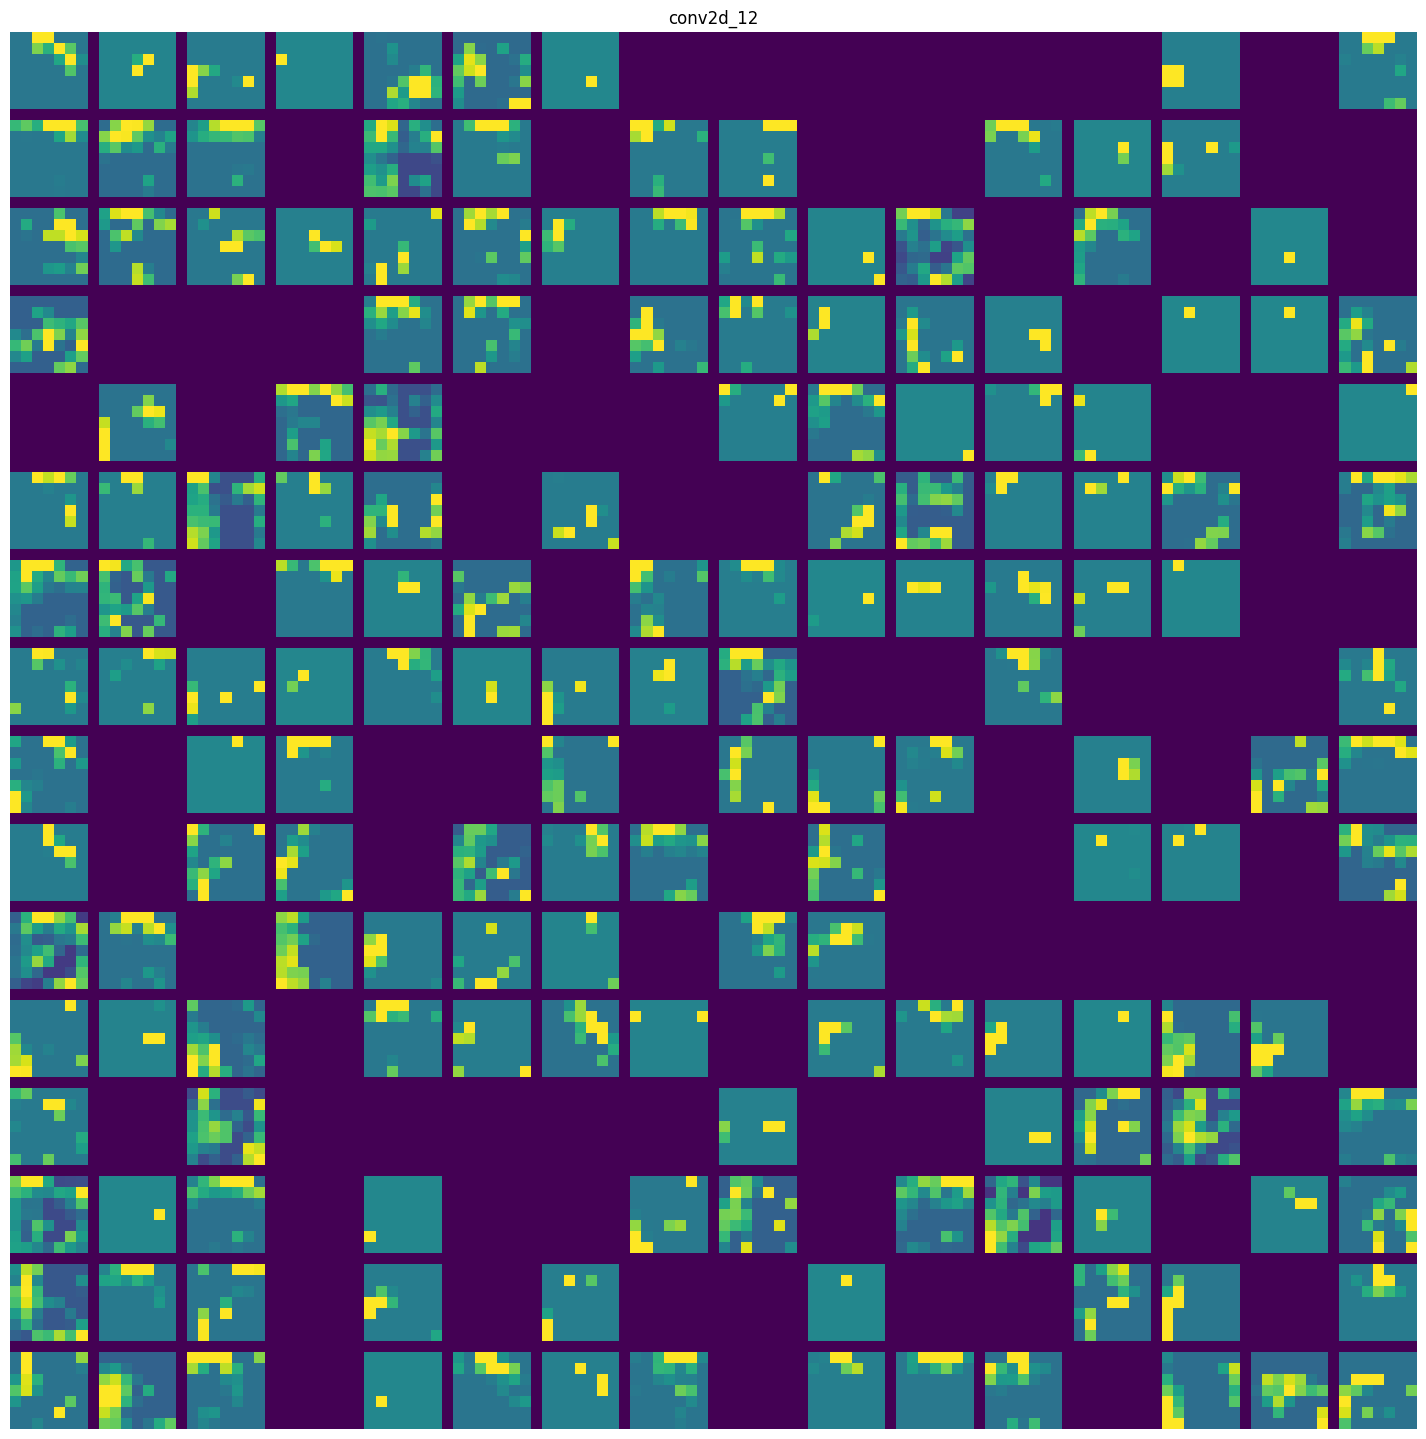

In [19]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
    images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.axis("off")
plt.imshow(display_grid, aspect="auto", cmap="viridis")

## Visualizing convnet filters

In [24]:
model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


In [25]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [26]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [27]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [29]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [30]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [31]:
img_width = 200
img_height = 200

In [32]:
def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [33]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

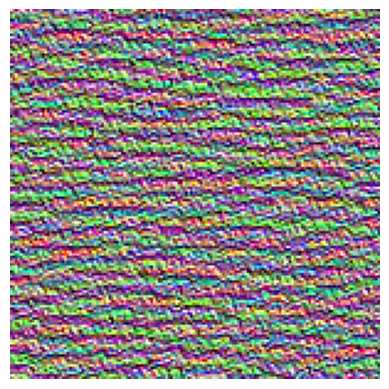

In [34]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))